In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
import efficientnet.keras as efn
import tensorflow as tf
import keras.backend as K
from keras.legacy import interfaces
from keras.optimizers import Optimizer
import runai.ga
from keras_gradient_accumulation import GradientAccumulation
import keras
import datetime
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
waste_types = ['cardboard','glass','metal','paper','plastic','trash','compost']
nb_classes = len(waste_types)
dataset_name = 'data'

In [3]:
from PIL import Image
import glob
def verify_dataset_images(dataset_name, waste_types): 
    subsets = ['train','valid']
    for subset in subsets:
        for waste_type in waste_types:
            waste_images = glob.glob(f'{dataset_name}/{subset}/{waste_type}/*')
            for image in waste_images:
                try:
                    Image.open(image)
                except:
                    print ("Error in ", image)
                    #os.remove(image)
                    
verify_dataset_images(dataset_name, waste_types)


In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = np.round(cm,2).astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(f'{title}.jpg')
    plt.show()

In [5]:
B0_PW_weights = "../more-data-model/B0-08-0.580013.hdf5"
B1_PW_weights = "../more-data-model/B1-08-0.003366.hdf5"
B2_PW_weights = "../more-data-model/B2-11-0.930438.hdf5"
B3_PW_weights = "../more-data-model/B3-09-0.287555.hdf5"
B4_PW_weights = "../more-data-model/B4-10-0.207060.hdf5"
B5_PW_weights = "../more-data-model/B5-10-0.178706.hdf5"
B6_PW_weights = "../more-data-model/B6-10-1.238215.hdf5"
B7_PW_weights = "../model/best_model-16-0.000003.hdf5"
B0_weights = "../model-b0-start/best_model-B0-26-1.744851.hdf5"
B1_weights = "../model-b1-start/best_model-B1-23-0.000070.hdf5"
B2_weights = "../model-b2-start/best_model-B2-15-0.080708.hdf5"
B3_weights = "../model-b3-start/best_model-B3-18-0.036295.hdf5"
B4_weights = "../model-b4-start/best_model-B4-07-1.461429.hdf5"
B5_weights = "../model-b5-start/best_model-B5-28-0.401363.hdf5"
B6_weights = "../model-b6-start/best_model-B6-08-1.243214.hdf5"
B7_weights = "../model-b7-start/best_model-B7-29-0.000320.hdf5"

In [6]:
def get_gradient_accumulation_steps(batch_size_actual,batch_size_required):
    return int(batch_size_required/batch_size_actual)

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
def initialize_vars(batch = 8, images_size = 224, data_folder = "data"):
    batch_size = batch
    img_size = images_size 
    
    train_datagen=ImageDataGenerator(rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
    )
    train_generator = train_datagen.flow_from_directory(
    f'{data_folder}//train',
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

    test_datagen = ImageDataGenerator(rescale=1./255)
    valid_generator=test_datagen.flow_from_directory(
    f'{data_folder}//valid',
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",    
    target_size=(img_size,img_size))
    
    
    return batch_size, img_size, train_generator, valid_generator

def get_model(modelType, weights = None, learning_rate = 0.0001):
    base_model = modelType

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(7, activation='softmax'))
    model.summary()

    optimizer = runai.ga.keras.optimizers.RMSprop(lr=learning_rate, steps = get_gradient_accumulation_steps(batch_size,16))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', f1_m])
    
    if weights != None:
        model.load_weights(weights)
    return model

def set_model_path(model_name, pretrained_weights = ""):
    if pretrained_weights != "":
        model_name = model_name+"-PW"
        
    model_path = f'models-{model_name}/'
    if not os.path.exists(model_path):
        os.mkdir(model_path)
    original_model_path = model_path + 'model-'+model_name+'.hdf5'
    loss_model_path = model_path + 'model-'+model_name+'-loss.hdf5'
    acc_model_path = model_path + 'model-'+model_name+'-acc.hdf5'
    return original_model_path, loss_model_path, acc_model_path

def select_model(model_name, img_size, pretrained=False):
    if model_name=="B0":
        model = efn.EfficientNetB0(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B0_weights
        else:
            weights = B0_PW_weights
    elif model_name=="B1":
        model = efn.EfficientNetB1(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B1_weights
        else:
            weights = B1_PW_weights
    elif model_name=="B2":
        model = efn.EfficientNetB2(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B2_weights
        else:
            weights = B2_PW_weights
    elif model_name=="B3":
        model = efn.EfficientNetB3(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B3_weights
        else:
            weights = B3_PW_weights
    elif model_name=="B4":
        model = efn.EfficientNetB4(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B4_weights
        else:
            weights = B4_PW_weights
    elif model_name=="B5":
        model = efn.EfficientNetB5(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B5_weights
        else:
            weights = B5_PW_weights
    elif model_name=="B6":
        model = efn.EfficientNetB6(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B6_weights
        else:
            weights = B6_PW_weights
    elif model_name=="B7":
        model = efn.EfficientNetB7(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B7_weights
        else:
            weights = B7_PW_weights
    if pretrained == True:
        model_path, loss_model_path, acc_model_path = set_model_path(model_name, True)
    else:
        model_path, loss_model_path, acc_model_path = set_model_path(model_name)
    return model, weights, model_path, loss_model_path, acc_model_path

def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size
def get_callbacks(loss_model_path,acc_model_path, patience = 10, min_lr = 0.00001, patience_dividing_factor = 2):
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

    patient = patience
    callbacks = [
        EarlyStopping(monitor='val_acc', patience=patient, mode='max', verbose=1),
        ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = int(patient / patience_dividing_factor), min_lr=min_lr, verbose=1, mode='min'),
        ModelCheckpoint(filepath=loss_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
        ModelCheckpoint(filepath=acc_model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
        tensorboard_callback
        ]
    return callbacks
def plot_graph(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Traing loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Trainging and validation loss')
    plt.legend()
    plt.show()
def get_results(model, data_folder, acc_model_path):
    test_datagen = ImageDataGenerator(rescale=1./255)

    valid_generator=test_datagen.flow_from_directory(
        f'{data_folder}//valid',
        batch_size=batch_size,
        shuffle=False,
        class_mode="categorical",    
        target_size=(img_size,img_size))
    
    model.load_weights(acc_model_path)
    Y_pred = model.predict_generator(valid_generator, 
                                 len(valid_generator.classes)//batch_size + 1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(valid_generator.classes, y_pred)
    disp = plot_confusion_matrix(cm,target_names = ['cardboard','compost','glass','metal',
                                      'paper','plastic','trash'])
    target_names = ['cardboard','glass','metal','paper','plastic','trash','compost']
    print(classification_report(valid_generator.classes, y_pred, target_names=target_names))
    print ("Accuracy-",accuracy_score(valid_generator.classes, y_pred))

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [18-06-2020 20:45:21.368] [17972] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 7175      
Total params: 5,372,579
Trainable params: 5,328,515
Non-trainable params: 44,064
_______________________________________

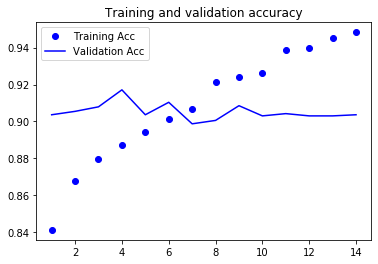

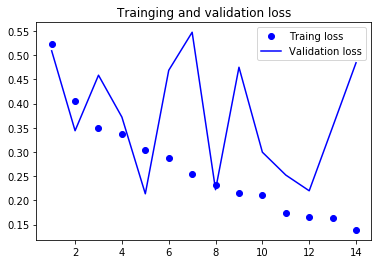

Found 1629 images belonging to 7 classes.
Confusion Matrix


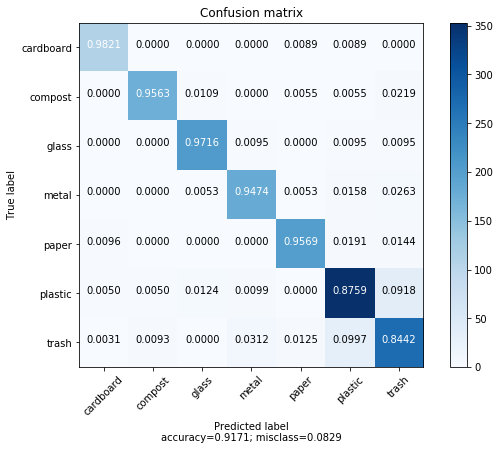

              precision    recall  f1-score   support

   cardboard       0.96      0.98      0.97       112
       glass       0.97      0.96      0.96       183
       metal       0.96      0.97      0.97       211
       paper       0.92      0.95      0.93       190
     plastic       0.97      0.96      0.96       209
       trash       0.89      0.88      0.88       403
     compost       0.84      0.84      0.84       321

    accuracy                           0.92      1629
   macro avg       0.93      0.93      0.93      1629
weighted avg       0.92      0.92      0.92      1629

models-B0/model-B0.hdf5
models-B0/model-B0-loss.hdf5
models-B0/model-B0-acc.hdf5


In [15]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B0", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 10, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 1629 images belonging to 7 classes.
Confusion Matrix


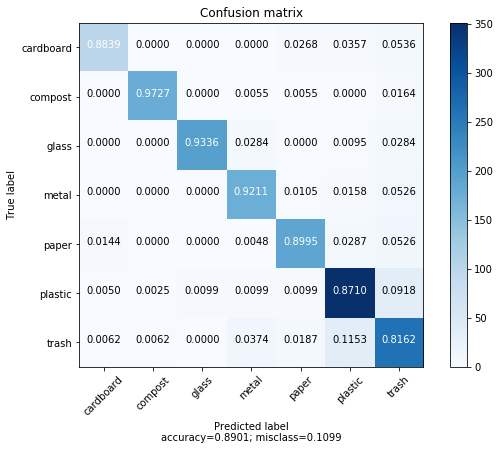

              precision    recall  f1-score   support

   cardboard       0.93      0.88      0.91       112
       glass       0.98      0.97      0.98       183
       metal       0.98      0.93      0.96       211
       paper       0.88      0.92      0.90       190
     plastic       0.92      0.90      0.91       209
       trash       0.87      0.87      0.87       403
     compost       0.78      0.82      0.80       321

    accuracy                           0.89      1629
   macro avg       0.91      0.90      0.90      1629
weighted avg       0.89      0.89      0.89      1629

Accuracy- 0.8901166359729895


In [22]:
"B0-scratch"
get_results(model, data_folder, acc_model_path)

In [ ]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B0", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 10, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [18-06-2020 21:16:28.821] [17972] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 7, 7, 1280)        6575232   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 7175      
Total params: 7,898,247
Trainable params: 7,834,151
Non-trainable params: 64,096
_______________________________________

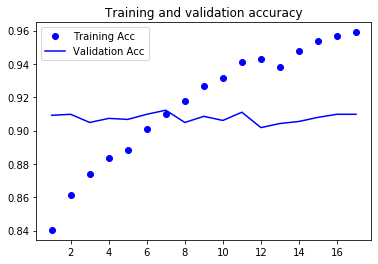

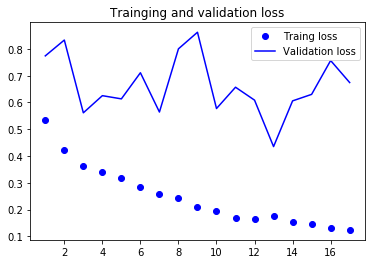

Found 1629 images belonging to 7 classes.
Confusion Matrix


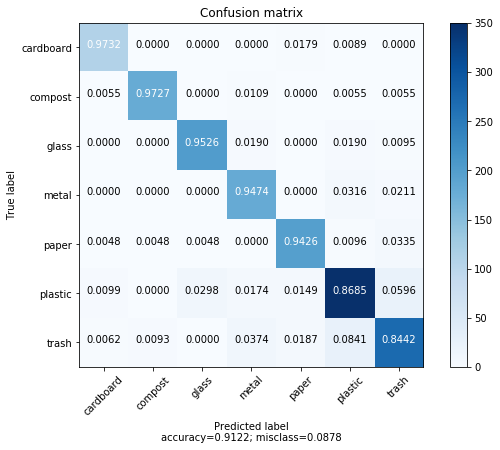

              precision    recall  f1-score   support

   cardboard       0.93      0.97      0.95       112
       glass       0.98      0.97      0.98       183
       metal       0.94      0.95      0.95       211
       paper       0.88      0.95      0.91       190
     plastic       0.93      0.94      0.94       209
       trash       0.90      0.87      0.88       403
     compost       0.88      0.84      0.86       321

    accuracy                           0.91      1629
   macro avg       0.92      0.93      0.92      1629
weighted avg       0.91      0.91      0.91      1629

Accuracy- 0.9122160834868017
models-B1/model-B1.hdf5
models-B1/model-B1-loss.hdf5
models-B1/model-B1-acc.hdf5


In [19]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B1", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 10, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

In [20]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B0", img_size, pretrained=True)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 10, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [18-06-2020 22:01:27.144] [17972] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 7175      
Total params: 5,372,579
Trainable params: 5,328,515
Non-trainable params: 44,064
_______________________________________

KeyboardInterrupt: 

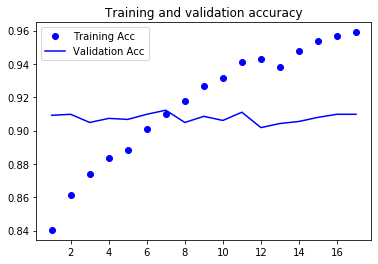

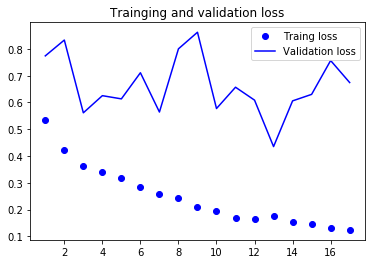

Found 1629 images belonging to 7 classes.
Confusion Matrix


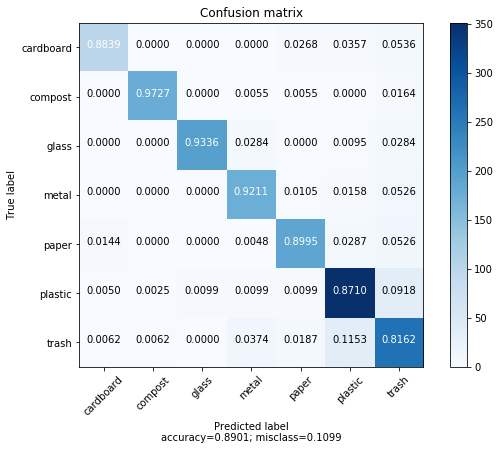

              precision    recall  f1-score   support

   cardboard       0.93      0.88      0.91       112
       glass       0.98      0.97      0.98       183
       metal       0.98      0.93      0.96       211
       paper       0.88      0.92      0.90       190
     plastic       0.92      0.90      0.91       209
       trash       0.87      0.87      0.87       403
     compost       0.78      0.82      0.80       321

    accuracy                           0.89      1629
   macro avg       0.91      0.90      0.90      1629
weighted avg       0.89      0.89      0.89      1629

Accuracy- 0.8901166359729895
models-B0/model-B0.hdf5
models-B0/model-B0-loss.hdf5
models-B0/model-B0-acc.hdf5


In [21]:
"B0-pretrained"
plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [18-06-2020 22:35:08.037] [17972] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 7, 7, 1280)        6575232   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 7175      
Total params: 7,898,247
Trainable params: 7,834,151
Non-trainable params: 64,096
_______________________________________

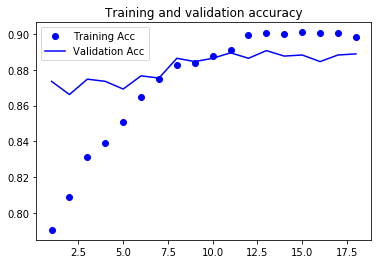

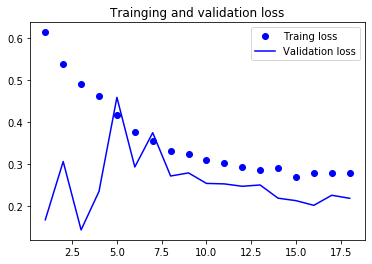

Found 1629 images belonging to 7 classes.
Confusion Matrix


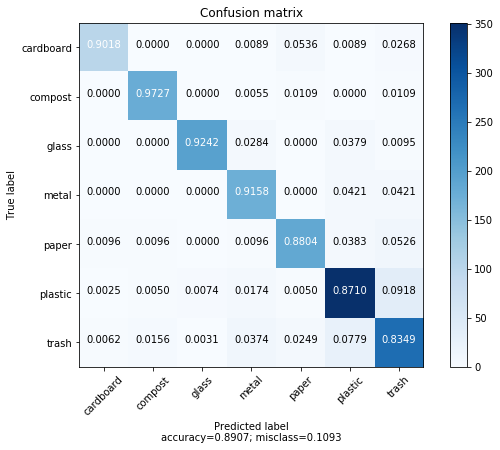

              precision    recall  f1-score   support

   cardboard       0.95      0.90      0.93       112
       glass       0.95      0.97      0.96       183
       metal       0.98      0.92      0.95       211
       paper       0.86      0.92      0.89       190
     plastic       0.91      0.88      0.90       209
       trash       0.88      0.87      0.87       403
     compost       0.81      0.83      0.82       321

    accuracy                           0.89      1629
   macro avg       0.91      0.90      0.90      1629
weighted avg       0.89      0.89      0.89      1629

Accuracy- 0.8907305095150398
models-B1/model-B1.hdf5
models-B1/model-B1-loss.hdf5
models-B1/model-B1-acc.hdf5


In [23]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B1", img_size, pretrained=True)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [18-06-2020 23:42:08.434] [17972] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Model)      (None, 7, 7, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1408)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              1442816   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_16 (Dense)             (None, 7)                 7175      
Total params: 9,222,649
Trainable params: 9,153,033
Non-trainable params: 69,616
_______________________________________

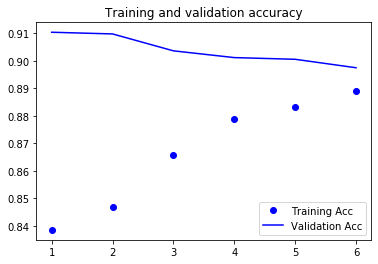

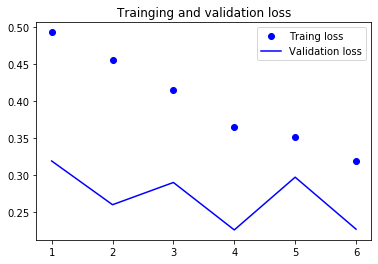

Found 1629 images belonging to 7 classes.
Confusion Matrix


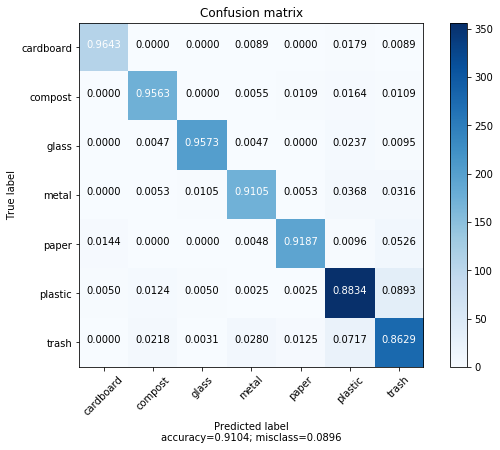

              precision    recall  f1-score   support

   cardboard       0.96      0.96      0.96       112
       glass       0.93      0.96      0.94       183
       metal       0.98      0.96      0.97       211
       paper       0.93      0.91      0.92       190
     plastic       0.96      0.92      0.94       209
       trash       0.89      0.88      0.89       403
     compost       0.83      0.86      0.84       321

    accuracy                           0.91      1629
   macro avg       0.92      0.92      0.92      1629
weighted avg       0.91      0.91      0.91      1629

Accuracy- 0.9103744628606507
models-B2/model-B2.hdf5
models-B2/model-B2-loss.hdf5
models-B2/model-B2-acc.hdf5


In [26]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B2", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

try:
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )
except:
    batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )

    

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [19-06-2020 00:13:34.803] [17972] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Model)      (None, 7, 7, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1408)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              1442816   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_18 (Dense)             (None, 7)                 7175      
Total params: 9,222,649
Trainable params: 9,153,033
Non-trainable params: 69,616
_______________________________________

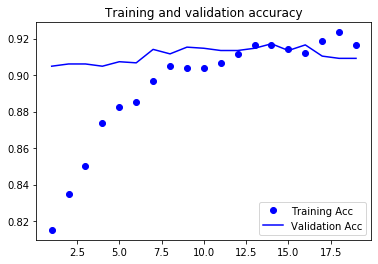

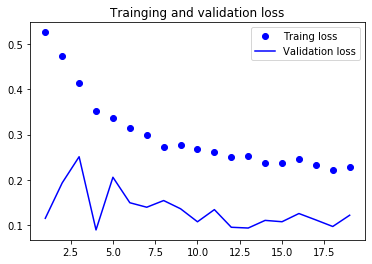

Found 1629 images belonging to 7 classes.
Confusion Matrix


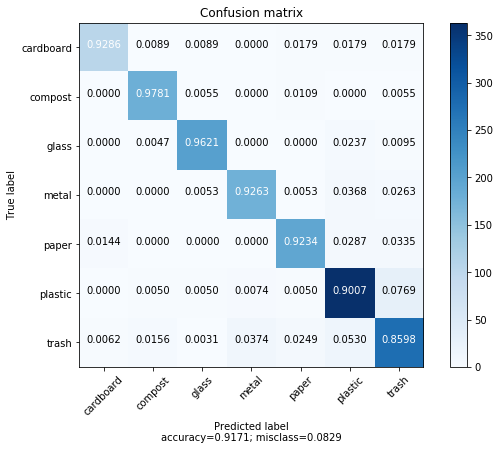

              precision    recall  f1-score   support

   cardboard       0.95      0.93      0.94       112
       glass       0.95      0.98      0.96       183
       metal       0.97      0.96      0.97       211
       paper       0.92      0.93      0.92       190
     plastic       0.93      0.92      0.93       209
       trash       0.91      0.90      0.90       403
     compost       0.85      0.86      0.86       321

    accuracy                           0.92      1629
   macro avg       0.93      0.93      0.93      1629
weighted avg       0.92      0.92      0.92      1629

Accuracy- 0.9171270718232044
models-B2-PW/model-B2-PW.hdf5
models-B2-PW/model-B2-PW-loss.hdf5
models-B2-PW/model-B2-PW-acc.hdf5


In [27]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B2", img_size, pretrained=True)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

try:
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )
except:
    batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )

    

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [19-06-2020 01:40:02.129] [17972] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_10  (None, 1536)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 7175      
Total params: 12,368,687
Trainable params: 12,279,343
Non-trainable params: 89,344
____________________________________

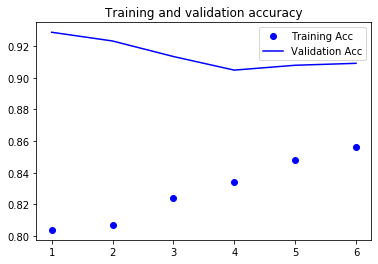

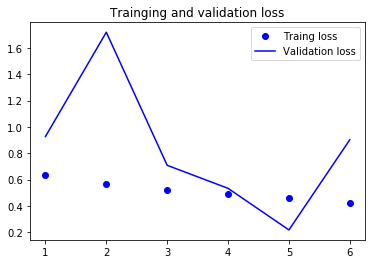

Found 1629 images belonging to 7 classes.
Confusion Matrix


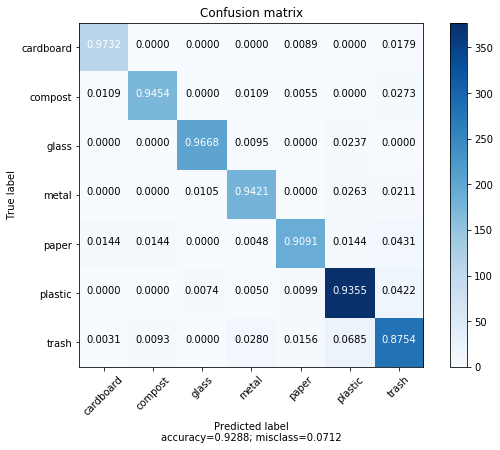

              precision    recall  f1-score   support

   cardboard       0.95      0.97      0.96       112
       glass       0.97      0.95      0.96       183
       metal       0.98      0.97      0.97       211
       paper       0.92      0.94      0.93       190
     plastic       0.95      0.91      0.93       209
       trash       0.92      0.94      0.93       403
     compost       0.88      0.88      0.88       321

    accuracy                           0.93      1629
   macro avg       0.94      0.94      0.94      1629
weighted avg       0.93      0.93      0.93      1629

Accuracy- 0.9287906691221608
models-B3/model-B3.hdf5
models-B3/model-B3-loss.hdf5
models-B3/model-B3-acc.hdf5


In [28]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B3", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

try:
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )
except:
    batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )

    

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [19-06-2020 02:19:37.534] [17972] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_11  (None, 1536)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 7175      
Total params: 12,368,687
Trainable params: 12,279,343
Non-trainable params: 89,344
____________________________________

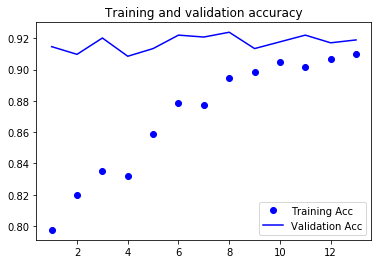

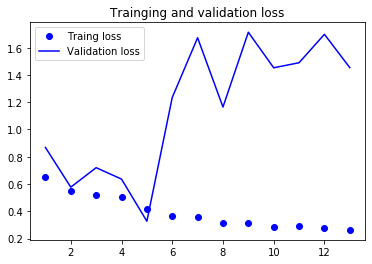

Found 1629 images belonging to 7 classes.
Confusion Matrix


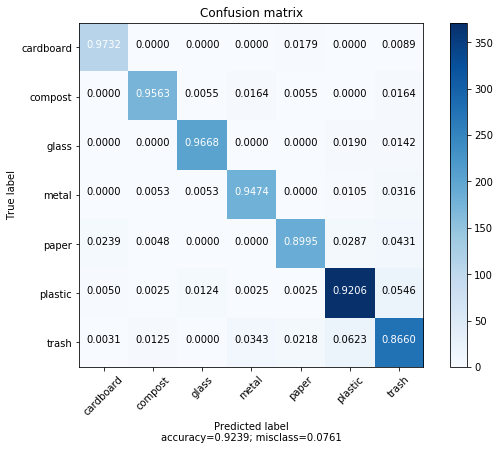

              precision    recall  f1-score   support

   cardboard       0.93      0.97      0.95       112
       glass       0.96      0.96      0.96       183
       metal       0.97      0.97      0.97       211
       paper       0.92      0.95      0.94       190
     plastic       0.94      0.90      0.92       209
       trash       0.92      0.92      0.92       403
     compost       0.86      0.87      0.86       321

    accuracy                           0.92      1629
   macro avg       0.93      0.93      0.93      1629
weighted avg       0.92      0.92      0.92      1629

Accuracy- 0.9238796807857581
models-B3/model-B3.hdf5
models-B3/model-B3-loss.hdf5
models-B3/model-B3-acc.hdf5


In [29]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B3", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

try:
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )
except:
    batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )

    

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [19-06-2020 03:44:01.350] [17972] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_12  (None, 1536)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_24 (Dense)             (None, 7)                 7175      
Total params: 12,368,687
Trainable params: 12,279,343
Non-trainable params: 89,344
____________________________________

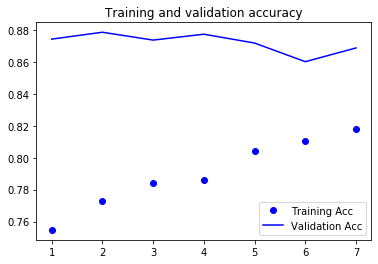

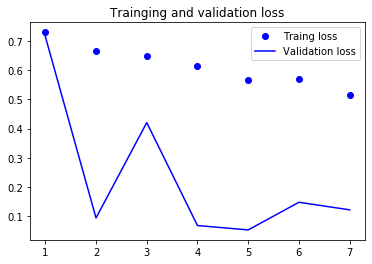

Found 1629 images belonging to 7 classes.
Confusion Matrix


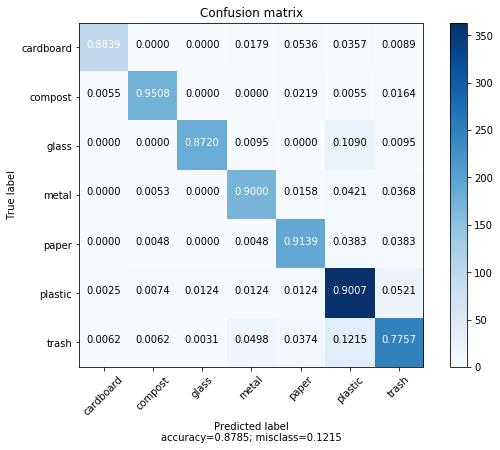

              precision    recall  f1-score   support

   cardboard       0.96      0.88      0.92       112
       glass       0.96      0.95      0.96       183
       metal       0.97      0.87      0.92       211
       paper       0.87      0.90      0.88       190
     plastic       0.86      0.91      0.89       209
       trash       0.81      0.90      0.86       403
     compost       0.86      0.78      0.81       321

    accuracy                           0.88      1629
   macro avg       0.90      0.89      0.89      1629
weighted avg       0.88      0.88      0.88      1629

Accuracy- 0.8784530386740331
models-B3-PW/model-B3-PW.hdf5
models-B3-PW/model-B3-PW-loss.hdf5
models-B3-PW/model-B3-PW-acc.hdf5


In [30]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B3", img_size, pretrained=True)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

try:
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )
except:
    batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )

    

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [19-06-2020 04:43:12.088] [17972] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_13  (None, 1792)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              1836032   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 7175      
Total params: 19,521,119
Trainable params: 19,393,871
Non-trainable params: 127,248
___________________________________

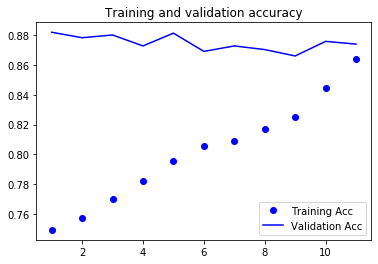

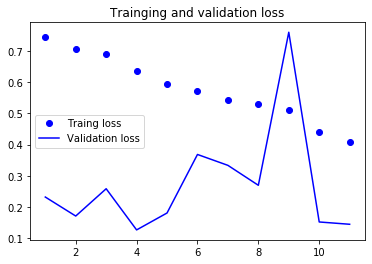

Found 1629 images belonging to 7 classes.
Confusion Matrix


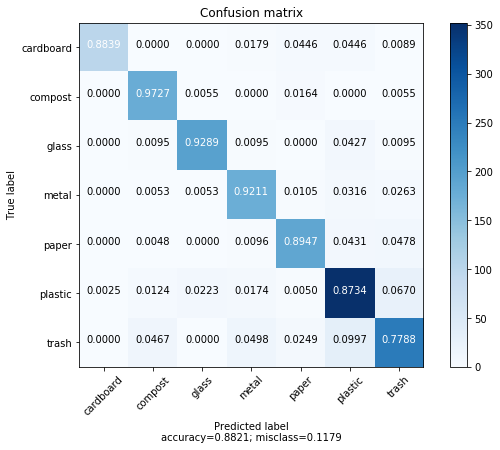

              precision    recall  f1-score   support

   cardboard       0.99      0.88      0.93       112
       glass       0.88      0.97      0.92       183
       metal       0.95      0.93      0.94       211
       paper       0.86      0.92      0.89       190
     plastic       0.90      0.89      0.90       209
       trash       0.85      0.87      0.86       403
     compost       0.84      0.78      0.81       321

    accuracy                           0.88      1629
   macro avg       0.90      0.89      0.89      1629
weighted avg       0.88      0.88      0.88      1629

Accuracy- 0.8821362799263351
models-B4/model-B4.hdf5
models-B4/model-B4-loss.hdf5
models-B4/model-B4-acc.hdf5


In [31]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B4", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 10, min_lr = 0.00001, patience_dividing_factor = 2)

try:
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )
except:
    batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )

    

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [19-06-2020 06:16:30.523] [17972] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_14  (None, 1792)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              1836032   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_28 (Dense)             (None, 7)                 7175      
Total params: 19,521,119
Trainable params: 19,393,871
Non-trainable params: 127,248
___________________________________

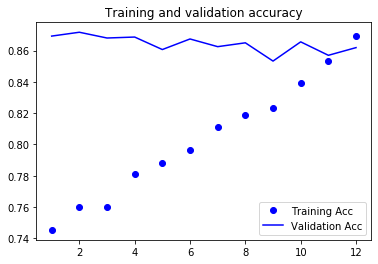

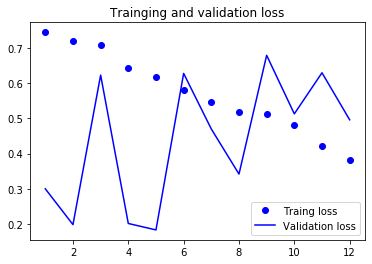

Found 1629 images belonging to 7 classes.


KeyboardInterrupt: 

In [32]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B4", img_size, pretrained=True)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 10, min_lr = 0.00001, patience_dividing_factor = 2)

try:
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )
except:
    batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )

    

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 1629 images belonging to 7 classes.
Confusion Matrix


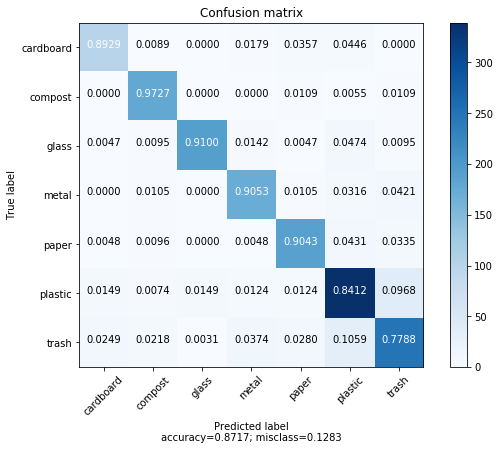

              precision    recall  f1-score   support

   cardboard       0.86      0.89      0.88       112
       glass       0.91      0.97      0.94       183
       metal       0.96      0.91      0.94       211
       paper       0.88      0.91      0.89       190
     plastic       0.89      0.90      0.90       209
       trash       0.84      0.84      0.84       403
     compost       0.81      0.78      0.79       321

    accuracy                           0.87      1629
   macro avg       0.88      0.89      0.88      1629
weighted avg       0.87      0.87      0.87      1629

Accuracy- 0.8717004297114794
models-B4-PW/model-B4-PW.hdf5
models-B4-PW/model-B4-PW-loss.hdf5
models-B4-PW/model-B4-PW-acc.hdf5


In [33]:
"B4-Pretrained"
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [19-06-2020 08:36:38.368] [18716] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 2 steps


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 7175      
Total params: 30,622,967
Trainable params: 30,448,183
Non-trainable params: 174,784
____________________________________

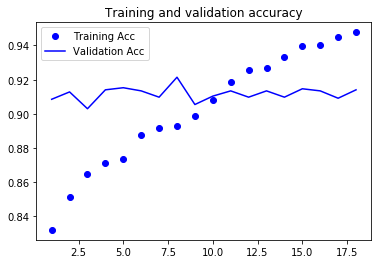

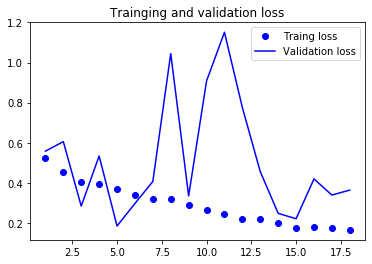

Found 1629 images belonging to 7 classes.
Confusion Matrix


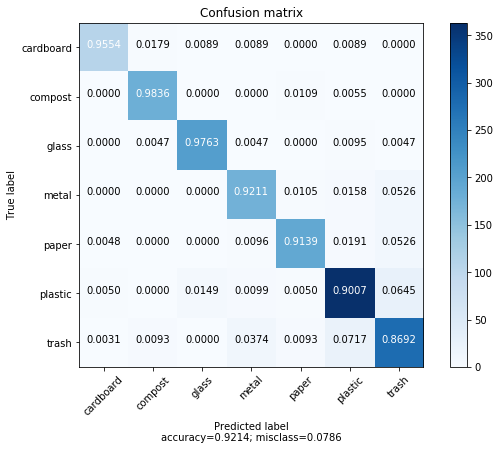

              precision    recall  f1-score   support

   cardboard       0.96      0.96      0.96       112
       glass       0.97      0.98      0.98       183
       metal       0.97      0.98      0.97       211
       paper       0.90      0.92      0.91       190
     plastic       0.95      0.91      0.93       209
       trash       0.91      0.90      0.91       403
     compost       0.85      0.87      0.86       321

    accuracy                           0.92      1629
   macro avg       0.93      0.93      0.93      1629
weighted avg       0.92      0.92      0.92      1629

Accuracy- 0.9214241866175568
models-B5/model-B5.hdf5
models-B5/model-B5-loss.hdf5
models-B5/model-B5-acc.hdf5


In [10]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B5", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 10, min_lr = 0.00001, patience_dividing_factor = 2)


#batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

    

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

In [11]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B5", img_size, pretrained=True)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 10, min_lr = 0.00001, patience_dividing_factor = 2)

try:
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )
except:
    try:
        batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
        history = model.fit_generator(
            train_generator,
            steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
            epochs=100,
            validation_data=valid_generator,
            validation_steps=get_steps(len(valid_generator.filenames), batch_size),
            verbose=1,
            callbacks = callbacks
        )
    except:
        batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 4, images_size = 224, data_folder = "data")
        history = model.fit_generator(
            train_generator,
            steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
            epochs=100,
            validation_data=valid_generator,
            validation_steps=get_steps(len(valid_generator.filenames), batch_size),
            verbose=1,
            callbacks = callbacks
        )

    

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [19-06-2020 10:21:21.252] [18716] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 2 steps


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 7175      
Total params: 30,622,967
Trainable params: 30,448,183
Non-trainable params: 174,784
____________________________________

KeyboardInterrupt: 

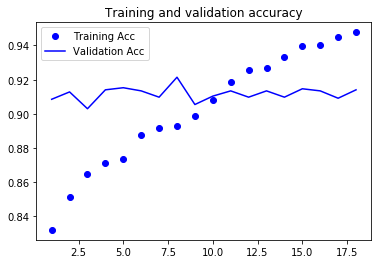

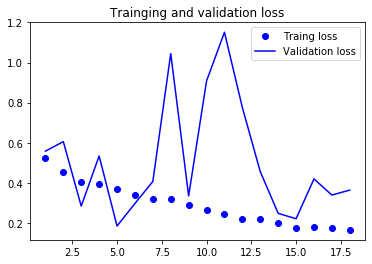

Found 1629 images belonging to 7 classes.
Confusion Matrix


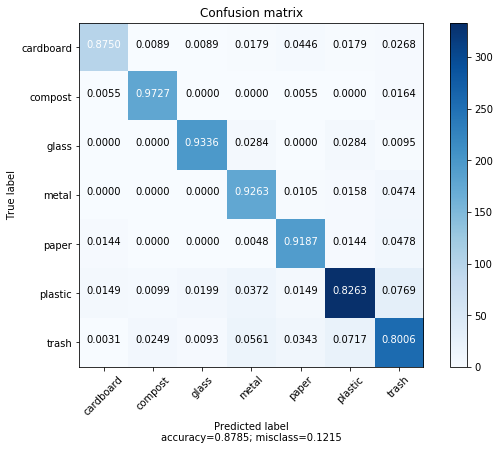

              precision    recall  f1-score   support

   cardboard       0.90      0.88      0.89       112
       glass       0.93      0.97      0.95       183
       metal       0.94      0.93      0.94       211
       paper       0.81      0.93      0.86       190
     plastic       0.88      0.92      0.90       209
       trash       0.90      0.83      0.86       403
     compost       0.82      0.80      0.81       321

    accuracy                           0.88      1629
   macro avg       0.88      0.89      0.89      1629
weighted avg       0.88      0.88      0.88      1629

Accuracy- 0.8784530386740331
models-B5-PW/model-B5-PW.hdf5
models-B5-PW/model-B5-PW-loss.hdf5
models-B5-PW/model-B5-PW-acc.hdf5


In [12]:
plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [19-06-2020 11:28:09.952] [18716] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 4 steps


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 7, 7, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2304)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2360320   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 7175      
Total params: 43,331,727
Trainable params: 43,105,247
Non-trainable params: 226,480
____________________________________

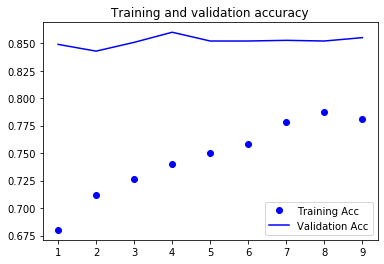

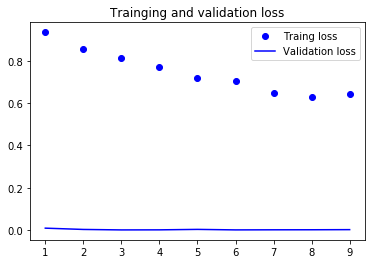

Found 1629 images belonging to 7 classes.
Confusion Matrix


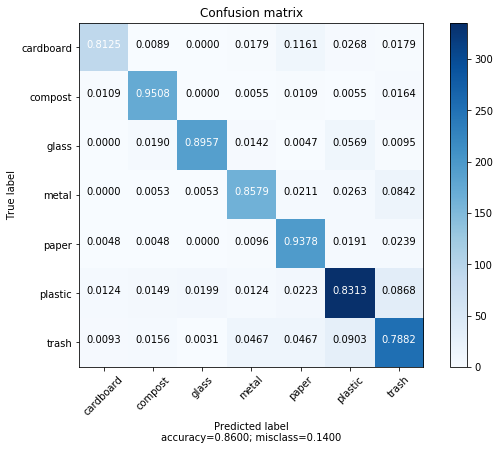

              precision    recall  f1-score   support

   cardboard       0.89      0.81      0.85       112
       glass       0.91      0.95      0.93       183
       metal       0.95      0.90      0.92       211
       paper       0.85      0.86      0.86       190
     plastic       0.82      0.94      0.87       209
       trash       0.86      0.83      0.85       403
     compost       0.80      0.79      0.79       321

    accuracy                           0.86      1629
   macro avg       0.87      0.87      0.87      1629
weighted avg       0.86      0.86      0.86      1629

Accuracy- 0.860036832412523
models-B6/model-B6.hdf5
models-B6/model-B6-loss.hdf5
models-B6/model-B6-acc.hdf5


In [14]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 4, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B6", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

In [15]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 4, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B6", img_size, pretrained=True)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


KeyboardInterrupt: 

In [ ]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 4, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B7", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[Run:AI] [DEBUG   ] [20-06-2020 01:24:08.381] [16692] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 4 steps


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2622464   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 7175      
Total params: 66,731,415
Trainable params: 66,418,647
Non-trainable params: 312,768
____________________________________

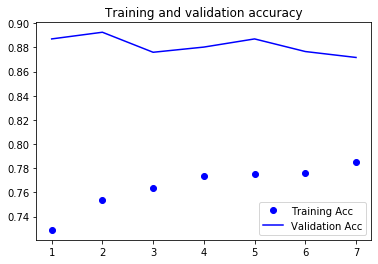

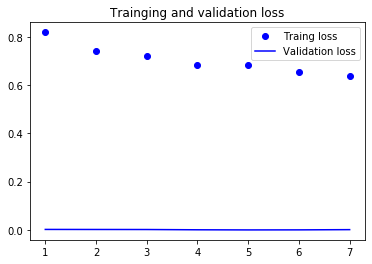

Found 1629 images belonging to 7 classes.
Confusion Matrix


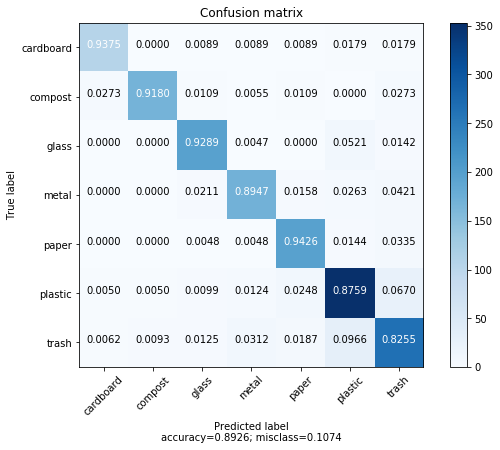

              precision    recall  f1-score   support

   cardboard       0.92      0.94      0.93       112
       glass       0.97      0.92      0.94       183
       metal       0.92      0.93      0.93       211
       paper       0.90      0.89      0.90       190
     plastic       0.90      0.94      0.92       209
       trash       0.87      0.88      0.87       403
     compost       0.84      0.83      0.83       321

    accuracy                           0.89      1629
   macro avg       0.90      0.90      0.90      1629
weighted avg       0.89      0.89      0.89      1629

Accuracy- 0.892572130141191
models-B7/model-B7.hdf5
models-B7/model-B7-loss.hdf5
models-B7/model-B7-acc.hdf5


In [8]:
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 4, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B7", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [19-06-2020 13:11:18.202] [18716] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1536)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 7175      
Total params: 12,368,687
Trainable params: 12,279,343
Non-trainable params: 89,344
_____________________________________

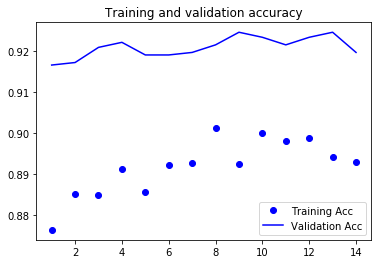

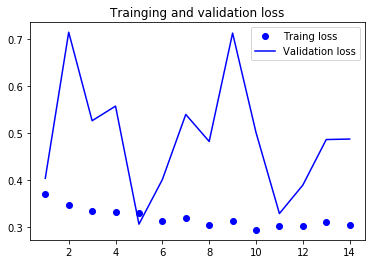

Found 1629 images belonging to 7 classes.
Confusion Matrix


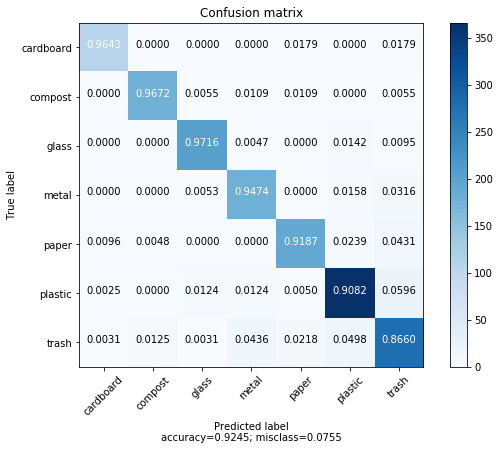

              precision    recall  f1-score   support

   cardboard       0.96      0.96      0.96       112
       glass       0.97      0.97      0.97       183
       metal       0.96      0.97      0.97       211
       paper       0.89      0.95      0.92       190
     plastic       0.94      0.92      0.93       209
       trash       0.93      0.91      0.92       403
     compost       0.86      0.87      0.86       321

    accuracy                           0.92      1629
   macro avg       0.93      0.93      0.93      1629
weighted avg       0.92      0.92      0.92      1629

Accuracy- 0.9244935543278084
models-B3/model-B3.hdf5
models-B3/model-B3-loss.hdf5
models-B3/model-B3-acc.hdf5


In [18]:
##Finetuning B3
data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B3", img_size, pretrained=False)
model = get_model(model, loss_model_path, 0.00001)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.000001, patience_dividing_factor = 2)
+-
try:90
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )
except:
    batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = "data")
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
        epochs=100,
        validation_data=valid_generator,
        validation_steps=get_steps(len(valid_generator.filenames), batch_size),
        verbose=1,
        callbacks = callbacks
    )

    

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

In [18]:
##Finetuning B0

data_folder = 'data'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = "data")
model, weights, model_path, loss_model_path, acc_model_path = select_model("B0", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 10, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 6505 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.


[Run:AI] [DEBUG   ] [19-06-2020 21:11:06.240] [18748] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 7175      
Total params: 5,372,579
Trainable params: 5,328,515
Non-trainable params: 44,064
_______________________________________

Epoch 24/100
407/407 [==============================] - 144s 354ms/step - loss: 0.1002 - acc: 0.9657 - f1_m: 0.9656 - val_loss: 1.0001 - val_acc: 0.9171 - val_f1_m: 0.9181

Epoch 00024: val_loss did not improve from 0.40526

Epoch 00024: val_acc did not improve from 0.92081
Epoch 25/100
407/407 [==============================] - 149s 365ms/step - loss: 0.0976 - acc: 0.9673 - f1_m: 0.9677 - val_loss: 0.9570 - val_acc: 0.9171 - val_f1_m: 0.9173

Epoch 00025: val_loss did not improve from 0.40526

Epoch 00025: val_acc did not improve from 0.92081
Epoch 26/100
407/407 [==============================] - 146s 358ms/step - loss: 0.0952 - acc: 0.9674 - f1_m: 0.9672 - val_loss: 0.9778 - val_acc: 0.9171 - val_f1_m: 0.9173

Epoch 00026: val_loss did not improve from 0.40526

Epoch 00026: val_acc did not improve from 0.92081
Epoch 27/100
 56/407 [===>..........................] - ETA: 1:42 - loss: 0.1008 - acc: 0.9654 - f1_m: 0.9652

KeyboardInterrupt: 

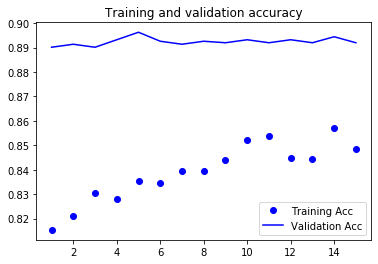

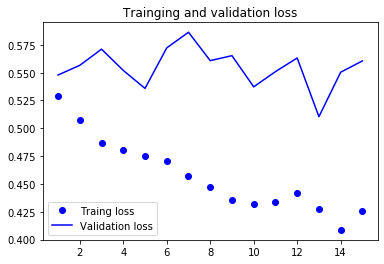

Found 1629 images belonging to 7 classes.
Confusion Matrix


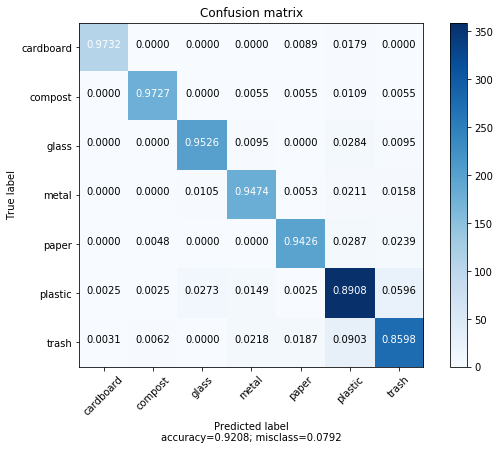

              precision    recall  f1-score   support

   cardboard       0.98      0.97      0.98       112
       glass       0.98      0.97      0.98       183
       metal       0.94      0.95      0.95       211
       paper       0.92      0.95      0.93       190
     plastic       0.95      0.94      0.95       209
       trash       0.88      0.89      0.89       403
     compost       0.89      0.86      0.87       321

    accuracy                           0.92      1629
   macro avg       0.93      0.93      0.93      1629
weighted avg       0.92      0.92      0.92      1629

Accuracy- 0.9208103130755064
models-B0/model-B0.hdf5
models-B0/model-B0-loss.hdf5
models-B0/model-B0-acc.hdf5


In [19]:
plot_graph(history)
get_results(model, data_folder, acc_model_path)
print (model_path, loss_model_path, acc_model_path, sep = '\n')